# Telecommunication_user_churn_classifier

## 1. Data Mining


In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
print("Libraries imported successfully.....")

Libraries imported successfully.....


In [2]:
#Importing data
df = pd.read_csv("telecom_customer_churn.csv")

print("Data imported successfully.....")

Data imported successfully.....


In [3]:
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN


## 2. Data Cleaning and EDA

In [4]:
#Separate numerical and categorical columns

from preprolib import myfunctions
num_cols = []
cat_cols = []

ignore_list = ['Zip Code', 'Longitude', 'Latitude', 
                'Customer ID', 'Churn Category', 
                'Churn Reason', 'Customer Status', 'City']

myfunctions.cat_or_num(df, ignore_list, num_cols, cat_cols)

label = 'Customer Status'


## 2.1 Exploratory Data Analysis


### 2.1 Data preprocessing


### 2.1.1 Numerical data


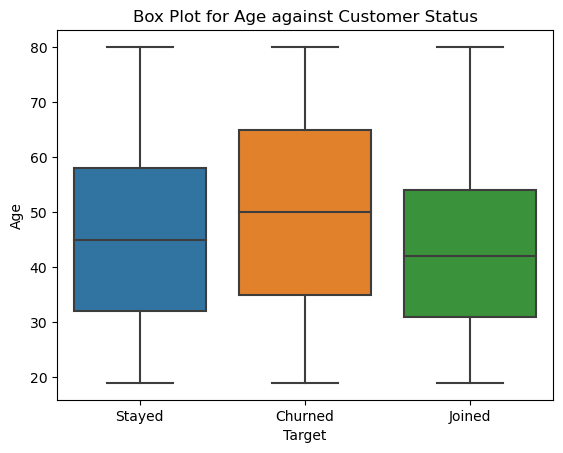

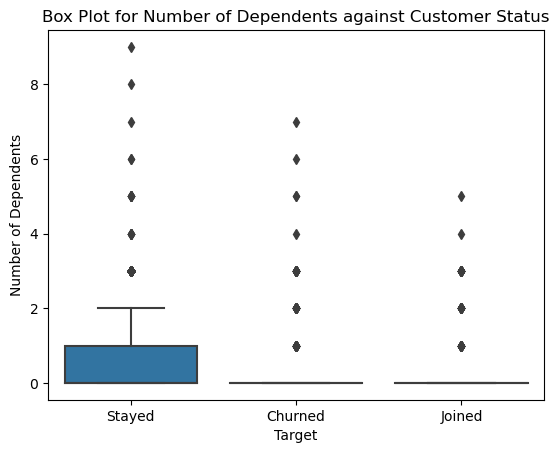

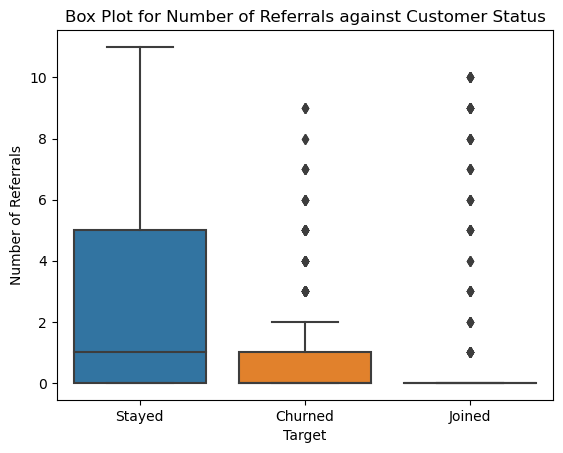

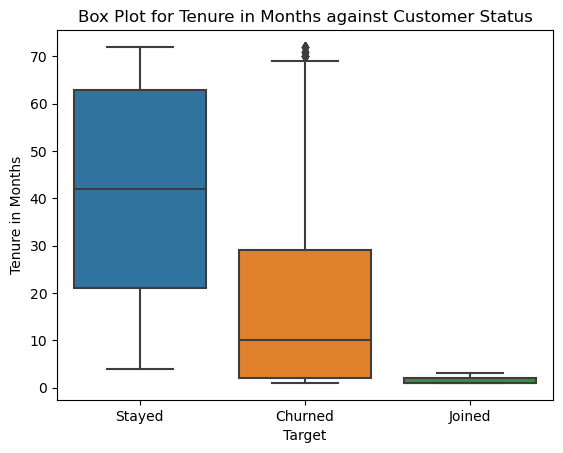

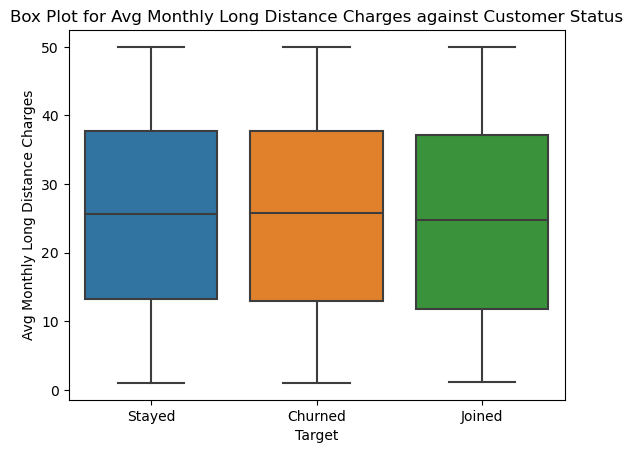

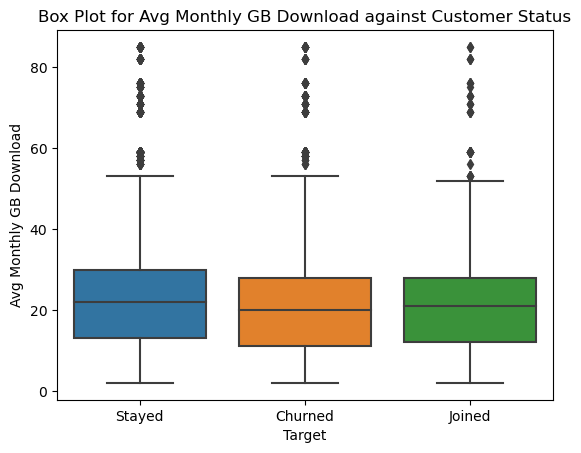

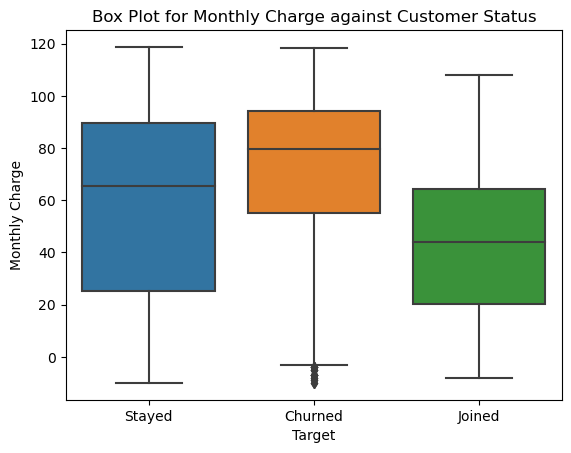

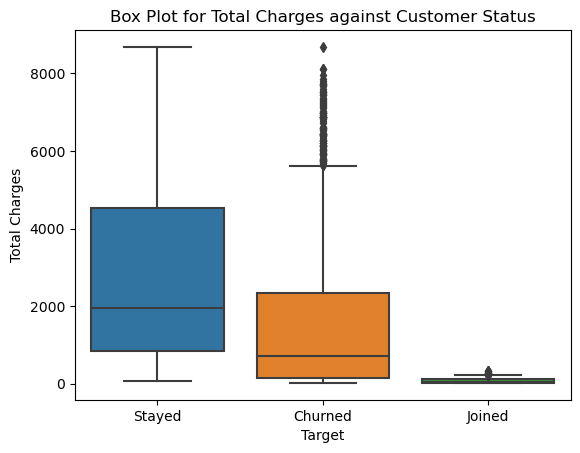

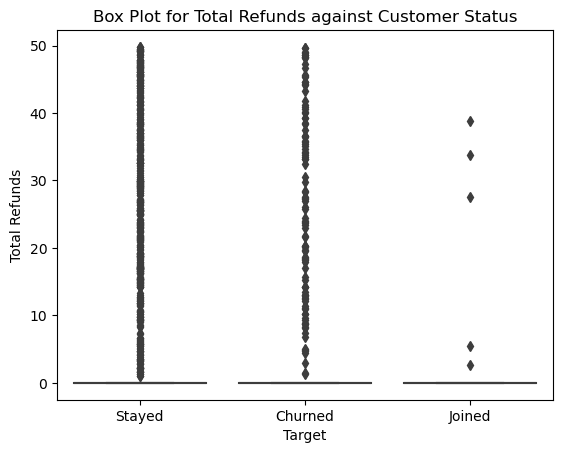

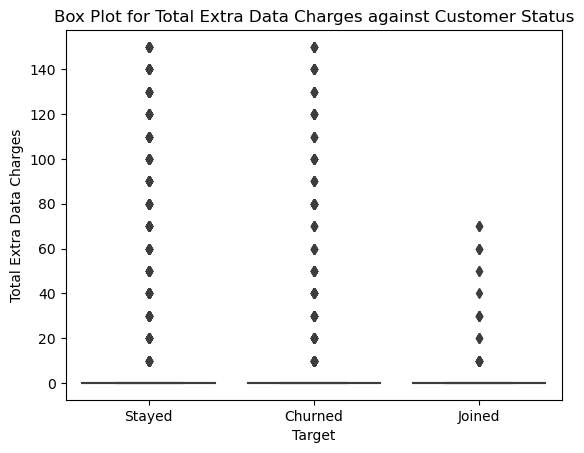

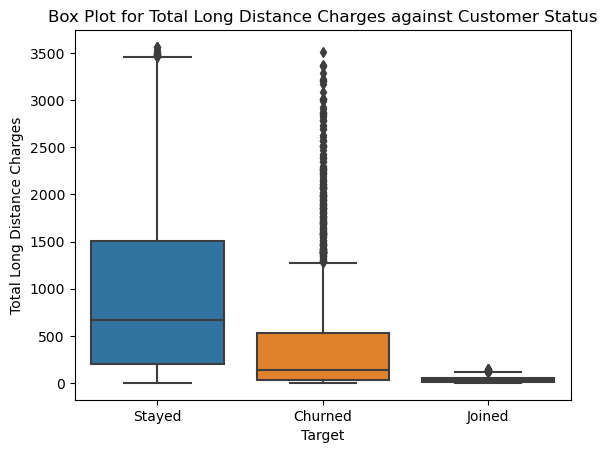

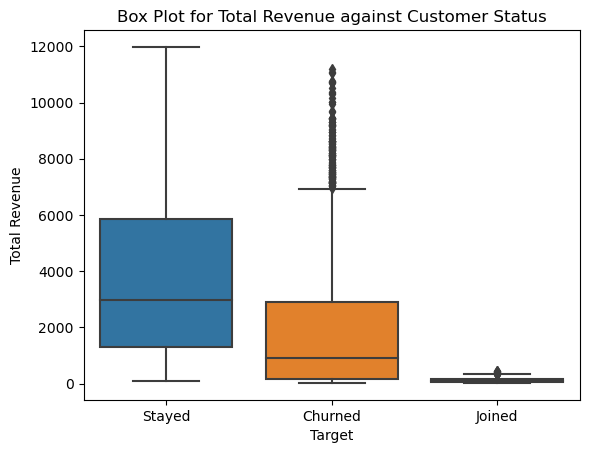

['Age',
 'Number of Dependents',
 'Number of Referrals',
 'Tenure in Months',
 'Avg Monthly Long Distance Charges',
 'Avg Monthly GB Download',
 'Monthly Charge',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue']

In [5]:
# Box plots for numerical data
for column in num_cols:
    plt.figure()  # Create a new figure for each box plot
    sns.boxplot(x='Customer Status', y=column, data=df)
    plt.title(f'Box Plot for {column} against {"Customer Status"}')
    plt.ylabel(column)
    plt.xlabel('Target')
    plt.show()

num_cols

#### Inferences
##### Age
Most users from age 30 to 60 stayed, 35 to 65 churned and 30 to 50 just joined. For the most part, age is too close to call as a factor for churn.

##### Number of Dependents
The relationship between number of dependents and Customer status is linear as the more dependents there are the less likely to churn the user is. *To confirm after scaling.*

##### Number of Referrals
A relationship between number of referances and Customer status is also linear as the more a user refers other customers, the higher the likelyhood they stay. *To confirm this fact after scaling*

##### Tenure in Months
The relationship between Tenure in Months and Customer status is also linear as the longer the customer tenure the more likely they stay. *To confirm after smoothing and scaling*


##### Avg Monthly Long distance Charges
The facts provided by the graph is inconclusive. The uniformity of it is quite compelling but the graphs for avg monthly long distance charges against each respective status are identical. Might lead to overfitting.

##### Avg Monthly GB Download
Same as above. Plus tons of outliers.

##### Monthly Charge
The lower the monthly charge the more likely the user is to stay. Hence we must take our attention to the data plans columns to check which influences churn the most and also their details. (Should check if we are to discard this.)

##### Total Charges.
I am puzzled here. Monthly charge is a customers total charge per month and total charge calculated at the end of each quarter. Here, ths lower the charge the more chances of churn. *Further investigation to be done on the relationship and of course, smoothing*

##### Total Refunds
Interesting graph. Should smooth to get a better read.

##### Total Extra Data Charges
Interesting graph. Should smooth to get a better read.

##### Total Long Distance Charges
The higher the number of long distance charges the more likely they are to stay. Speaks to quality of long distance service.

##### Total Revenue 
The higher the revenue from a user the more likely they are to stay. Speaks to loyalty. 

In [6]:
##num_cols.remove('Age', 'Avg Long Distance Charge', 'Avg GB Download', 'Monthly Charge')

remove_num = ['Age', 'Avg Monthly Long Distance Charges',  'Avg Monthly GB Download', 'Monthly Charge']

num_cols = [x for x in num_cols if x not in remove_num]



In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Define the features and label
features = cat_cols + num_cols
label = 'Customer Status'

# Convert the label column to ordinal categories
label_encoder = OrdinalEncoder()
y = label_encoder.fit_transform(df[label].values.reshape(-1, 1))

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.3, random_state=0)

# Define a pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical columns
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer to apply the pipeline to the numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Fit the preprocessor to the training data and transform both the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Training Set: %d, Test Set: %d \n' % (len(X_train), len(X_test)))

# Print the transformed DataFrames
print("X_train_Transformed:\n", X_train_transformed)
print("\nX_test_Transformed:\n", X_test_transformed)

Training Set: 4930, Test Set: 2113 

X_train_Transformed:
 [[ 2.67193796  1.36376374  0.71684667 ...  1.          0.
   0.        ]
 [ 2.67193796 -0.64021696 -0.38338118 ...  0.          1.
   0.        ]
 [-0.48470094  1.36376374  0.55384995 ...  0.          1.
   0.        ]
 ...
 [-0.48470094 -0.64021696  0.18710734 ...  1.          0.
   0.        ]
 [-0.48470094 -0.64021696 -1.27986312 ...  1.          0.
   0.        ]
 [ 0.56751203 -0.30622017  1.4503319  ...  1.          0.
   0.        ]]

X_test_Transformed:
 [[ 0.56751203  0.36177339  0.59459913 ...  1.          0.
   0.        ]
 [-0.48470094 -0.64021696 -1.27986312 ...  1.          0.
   0.        ]
 [-0.48470094 -0.64021696  0.47235159 ...  0.          1.
   0.        ]
 ...
 [-0.48470094  0.02777661  0.96134175 ...  0.          1.
   0.        ]
 [ 1.61972499 -0.64021696 -0.09813692 ...  1.          0.
   0.        ]
 [-0.48470094  1.36376374  1.61332862 ...  1.          0.
   0.        ]]


## 3. Model Selection

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier#
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score


from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

#mcm = confusion_matrix(y_test, predictions)

lr_model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000).fit(X_train_transformed, y_train)
kn_model = KNeighborsClassifier().fit(X_train_transformed, y_train)
dt_model = DecisionTreeClassifier().fit(X_train_transformed, y_train)
rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)
nb_model = GaussianNB().fit(X_train_transformed, y_train)
ab_model = AdaBoostClassifier().fit(X_train_transformed, y_train)
#svc_model = SVC().fit(X_train_transformed,y_train)


models = [
    ('Logistic Regression', lr_model),
    ('K-Nearest Neighbors', kn_model),
    ('Decision Tree', dt_model),
    ('Random Forest', rf_model),
    ('Gaussian Naive Bayes', nb_model),
    ('AdaBoost', ab_model)
]


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\AppData\Local\Temp\ipykernel_6324\2557903111.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In [13]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Define lists to store model evaluation results
model_names = []
recall_scores = []
f1_scores = []
precision_scores = []
accuracy_scores = []
fold_numbers = []  # New list to store fold numbers

def evaluate_model(curr_model, model_name, X_test, y_test, fold_number):
    predictions = curr_model.predict(X_test)

    # Calculate the necessary metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    # Append model name and metric scores to the respective lists
    model_names.append(model_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    fold_numbers.append(fold_number)  # Add fold number for the current evaluation

## Model Evaluation using KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_number = 1  # Initialize fold number counter

for model_name, model in models:
    for train_index, test_index in kf.split(X_train_transformed):
        X_train_fold, X_test_fold = X_train_transformed[train_index], X_train_transformed[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        model.fit(X_train_fold, y_train_fold)
        evaluate_model(model, model_name, X_test_fold, y_test_fold, fold_number)
        fold_number += 1  # Increment fold number for the next evaluation

# Create a DataFrame to store the model evaluation results
model_evaluation_df = pd.DataFrame({
    'Fold': fold_numbers,  # New column for fold numbers
    'Model': model_names,
    'Recall': recall_scores,
    'F1-score': f1_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores
})

# Print the DataFrame with model evaluation results
# Sort the DataFrame by accuracy in descending order
model_evaluation_df.sort_values(by='Accuracy', ascending=False, inplace=True)
model_evaluation_df.sort_values(by='Model', ascending=False, inplace=True)
model_evaluation_df.reset_index(drop=True, inplace=True)

print("\nModel Evaluation:")
print(model_evaluation_df)


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t


Model Evaluation:
    Fold                 Model    Recall  F1-score  Precision  Accuracy
0     19         Random Forest  0.839757  0.833779   0.832502  0.839757
1     17         Random Forest  0.811359  0.804490   0.803315  0.811359
2     16         Random Forest  0.824544  0.819362   0.816557  0.824544
3     18         Random Forest  0.824544  0.818729   0.817746  0.824544
4     20         Random Forest  0.817444  0.810574   0.809610  0.817444
5      3   Logistic Regression  0.836714  0.836514   0.839749  0.836714
6      1   Logistic Regression  0.810345  0.811224   0.812185  0.810345
7      5   Logistic Regression  0.800203  0.801082   0.802081  0.800203
8      2   Logistic Regression  0.815416  0.813285   0.813428  0.815416
9      4   Logistic Regression  0.830629  0.831019   0.831563  0.830629
10     8   K-Nearest Neighbors  0.764706  0.759868   0.766882  0.764706
11     7   K-Nearest Neighbors  0.782961  0.781176   0.787850  0.782961
12     9   K-Nearest Neighbors  0.778905  0.7

c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Calculate the mean performance metrics for each model across all folds
mean_performance = model_evaluation_df.groupby('Model').mean()

# Calculate the standard deviation of performance metrics for each model across all folds
std_performance = model_evaluation_df.groupby('Model').std()

# Print the mean and standard deviation of performance metrics
print("\nMean Performance across Folds:")
print(mean_performance)
print("\nStandard Deviation of Performance across Folds:")
print(std_performance)



Mean Performance across Folds:
                      Fold    Recall  F1-score  Precision  Accuracy
Model                                                              
AdaBoost              28.0  0.756592  0.701384   0.683308  0.756592
Decision Tree         13.0  0.777688  0.777781   0.778316  0.777688
Gaussian Naive Bayes  23.0  0.702637  0.722901   0.775802  0.702637
K-Nearest Neighbors    8.0  0.763489  0.763386   0.769476  0.763489
Logistic Regression    3.0  0.818661  0.818625   0.819801  0.818661
Random Forest         18.0  0.823529  0.817387   0.815946  0.823529

Standard Deviation of Performance across Folds:
                          Fold    Recall  F1-score  Precision  Accuracy
Model                                                                  
AdaBoost              1.581139  0.016773  0.021953   0.025704  0.016773
Decision Tree         1.581139  0.009685  0.008963   0.008010  0.009685
Gaussian Naive Bayes  1.581139  0.016074  0.013346   0.008688  0.016074
K-Nearest Neigh